# Generating tiles from the images

The full images are too large to work with so we decided to cut the image into tiles of 512x512, so that we could both annotate and run the cellpose model without using too much time and computer power.
In the tiling generation function we also discard empty tiles and try to remove tiles that are simply noise.

In [2]:
# Initilization
#image_path = r'/work/imaging_data_f2805_HEV/2023_07_14_F2805_w.16 A3+A4_iBALT.czi'

import numpy as np
import matplotlib.pyplot as plt
import os
from aicsimageio import AICSImage
import math
from PIL import Image
import random

## Load images

In [3]:
def load_images(image_path):
    """
    Load images from a .czi file.

    Args:
    - image_path (str): Path to the .czi file.

    Returns:
    - nuc_image_1 (np.ndarray): Data for the first scene.
    - nuc_image_2 (np.ndarray): Data for the second scene.
    - scene_names (list): List of scene names.
    """
    try:
        aics_img = AICSImage(image_path)

        scene_arrays = []
        scene_names = []

        for scene in aics_img.scenes:
            scene_names.append(scene)

            # Get scene
            aics_img.set_scene(scene)

            # Get the data for this scene (as numpy array)
            data = aics_img.get_image_data("XYC", T=0)  # This will return data for the currently active scene
            
            # Append the numpy array to the list
            scene_arrays.append(data)

        nuc_image_1 = scene_arrays[0].squeeze()
        nuc_image_2 = scene_arrays[1].squeeze()

        return nuc_image_1, nuc_image_2, scene_names

    except IOError as err:
        print("Image path does not exist", str(err))
        raise
    except Exception as e:
        print("Error loading .czi file:", str(e))
        raise


In [4]:
####### Print random images - to visualize different tiles
def display_random_tiles(output_dir, num_tiles=5):
    """
    Display a few random tiles from the generated tiles directory.

    Args:
    - output_dir (str): Path to the output directory containing tiles.
    - num_tiles (int, optional): Number of tiles to display. Default is 5.
    """
    all_tiles = []

    # Walk through the output directory and collect all tile paths
    for root, _, files in os.walk(output_dir):
        for file in files:
            if file.endswith(".png"):
                all_tiles.append(os.path.join(root, file))

    if not all_tiles:
        print("No tiles found in the specified output directory.")
        return

    # Randomly sample tiles to display
    sampled_tiles = random.sample(all_tiles, min(num_tiles, len(all_tiles)))

    # Set up the plot
    plt.figure(figsize=(15, 5))
    for idx, tile_path in enumerate(sampled_tiles, 1):
        tile = Image.open(tile_path)

        # Plot each tile
        plt.subplot(1, len(sampled_tiles), idx)
        plt.imshow(tile, cmap="gray") 
        plt.title(f"Tile: {os.path.basename(tile_path)}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

In [5]:
# Checking the levels for the thresholds
def get_tile_variance(tile_filename, channel_count, tile_size=512, overlap=0, input_path=None):
    """
    Calculate the variance of a specific tile across all channels and show the tile images.

    Args:
    - tile_filename (str): The filename of the tile to check (e.g., 'tile_0000_0031').
    - channel_count (int): Number of channels in the image (for iterating over channels).
    - tile_size (int): Size of the tiles. Default is 512.
    - overlap (int): Overlap of the tiles. Default is 0.
    - input_path (str): Path to the directory where the tile images are stored.

    Returns:
    - variance_dict (dict): A dictionary with the variance values for each channel.
    """
    variance_dict = {}

    # Ensure input path exists
    if not os.path.isdir(input_path):
        print(f"Directory {input_path} not found.")
        return variance_dict

    # Prepare a figure for displaying the images
    fig, axes = plt.subplots(1, channel_count, figsize=(15, 5))

    # If only one channel, axes will not be a list, so ensure it's iterable
    if channel_count == 1:
        axes = [axes]

    # Iterate over each channel
    for channel in range(channel_count):
        # Construct the full path for the tile image in the given channel
        tile_path = os.path.join(input_path, f"channel_{channel}", tile_filename + ".png")

        if not os.path.isfile(tile_path):
            print(f"Tile {tile_path} not found.")
            continue

        # Open the tile image using PIL and convert to numpy array
        tile_image = Image.open(tile_path)
        tile_array = np.array(tile_image)

        # Calculate the variance of the tile
        tile_variance = np.var(tile_array)
        variance_dict[channel] = tile_variance
        print(f"Variance of {tile_filename} in channel {channel}: {tile_variance}")

        # Display the image in the corresponding subplot
        axes[channel].imshow(tile_array, cmap='gray')
        axes[channel].set_title(f"Channel {channel}")
        axes[channel].axis('off')  # Hide axis for better visual display

    # Show the images
    plt.tight_layout()
    plt.show()

    return variance_dict



## Generate

In [6]:
def generate_deepzoom_tiles_from_czi(input_path, output_dir, tile_size=512, overlap=0, intensity_threshold=10, min_threshold=300, noise_threshold=100):
    """
    Generate deep zoom tiles from a .czi file and save all tiles with a condition that background tiles
    (those with average intensity below a threshold) are not saved.
    Additionally, a background threshold is applied to the image to remove low-intensity pixels.

    Args:
    - input_path (str): Path to the .czi file.
    - output_dir (str): Directory to save the tiles.
    - tile_size (int, optional): Size of the tiles. Default is 512.
    - overlap (int, optional): Overlap of the tiles. Default is 0.
    - intensity_threshold (int, optional): Intensity threshold to identify background tiles. Default is 10.
    - min_threshold (int, optional): Minimum threshold for pixel intensity to remove background pixels. Default is 10.
    - noise_threshold (int, optional): Variance threshold to identify noisy tiles. Default is 100.
    """
    if not os.path.isfile(input_path) or not input_path.endswith(".czi"):
        print("Invalid input path or file is not a .czi file.")
        return

    # Extract the filename from the path
    filename = os.path.basename(input_path)

    # Load and preprocess images
    try:
        nuc_image_1, nuc_image_2, scene_names = load_images(input_path)
    except Exception as e:
        print(f"Error loading images: {e}")
        return

    # Initialize a counter for the total number of tiles
    total_tiles_created = 0

    # Process both scenes (nuc_image_1 and nuc_image_2)
    for scene_idx, image_data in enumerate([nuc_image_1, nuc_image_2]):
        print(f"Processing Scene {scene_idx + 1}/{len(scene_names)}: {scene_names[scene_idx]}")
        scene_dir = os.path.join(output_dir, f"scene_{scene_idx}")
        os.makedirs(scene_dir, exist_ok=True)

        # Get dimensions (X, Y, C)
        height, width, channels = image_data.shape

        for channel in range(channels):  # Loop over channels
            channel_dir = os.path.join(scene_dir, f"channel_{channel}")
            os.makedirs(channel_dir, exist_ok=True)

            img = image_data[:, :, channel]  # Extract the channel
            # for debugging: print(f"Processing channel {channel}, dimensions: {width}x{height}")

            # Apply background threshold to remove low-intensity pixels
            img[img < min_threshold] = 0

            # Apply upper  threshold to remove low-intensity pixels
            img[img > 2500] = 2500

            num_tiles_x = math.ceil(width / tile_size)
            num_tiles_y = math.ceil(height / tile_size)

            for tile_x in range(num_tiles_x):
                for tile_y in range(num_tiles_y):
                    # Calculate tile bounds
                    tile_left = tile_x * tile_size
                    tile_top = tile_y * tile_size
                    tile_right = min(tile_left + tile_size + overlap, width)
                    tile_bottom = min(tile_top + tile_size + overlap, height)

                    tile = img[tile_top:tile_bottom, tile_left:tile_right]

                    # Check if the tile is background (i.e., intensity below the threshold)
                    avg_intensity = np.mean(tile)
                    if avg_intensity < intensity_threshold:
                        # for debugging: print(f"Skipping background tile at ({tile_x}, {tile_y}) with average intensity: {avg_intensity}")
                        continue  # Skip this tile if it's background

                    # Check if the tile is noisy (i.e., low variance)
                    tile_variance = np.var(tile)
                    if tile_variance < noise_threshold:
                        #for debugging: print(f"Skipping noisy tile at ({tile_x}, {tile_y}) with variance: {tile_variance}")
                        continue  # Skip this tile if it is considered noisy

                    # Save the tile if it's not background, not noisy
                    tile_filename = f"tile_{tile_x:04d}_{tile_y:04d}_image.png"
                    tile_path = os.path.join(channel_dir, tile_filename)

                    # Convert tile to PIL Image and save as PNG
                    tile_image = Image.fromarray((tile / tile.max() * 255).astype(np.uint8))  # Convert to 8-bit image
                    tile_image.save(tile_path, "PNG")
                    #print(f"Saved tile: {tile_path}")
                    
                    # Increment the counter for each saved tile
                    total_tiles_created += 1

    print(f"CZI tile generation complete. Total tiles created: {total_tiles_created}")


In [7]:
# Define input and output paths
#image_path = r'/work/imaging_data_f2805_HEV/2023_07_14_F2805_w.16 A3+A4_iBALT.czi'

input_czi_path =r'/work/imaging_data_f2805_HEV/2023_07_14_F2805_w.16 A3+A4_iBALT.czi'  # Replace with your .czi file path
output_dir = "./output_tiles/"  # Replace with your desired output directory

# Parameters
tile_size = 512  # Size of each tile
overlap = 0      # Overlap in pixels between tiles

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Call the function to generate tiles
generate_deepzoom_tiles_from_czi(input_czi_path, output_dir, tile_size, overlap)

Processing Scene 1/2: ScanRegion2
Processing Scene 2/2: ScanRegion3
CZI tile generation complete. Total tiles created: 6892


# Check

#

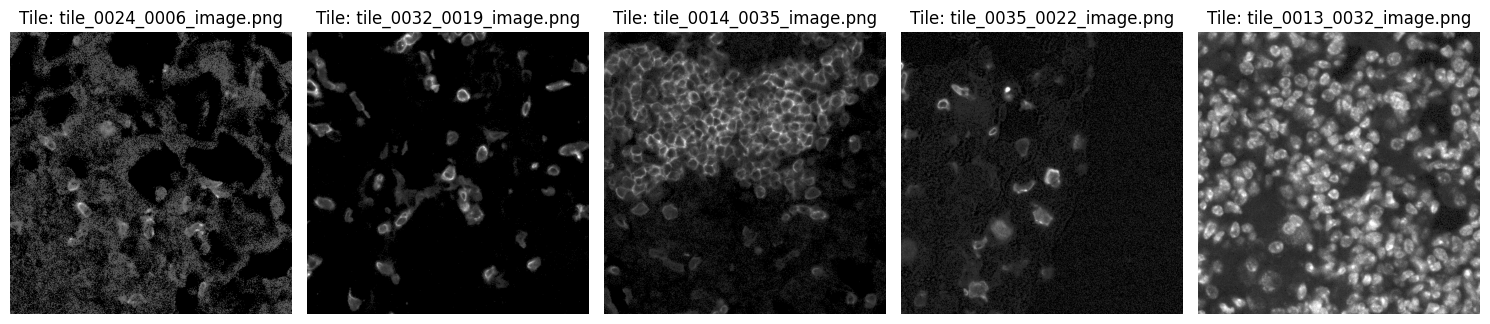

In [8]:
### Tile images
display_random_tiles(output_dir, num_tiles=5)

Variance of tile_0028_0011_image in channel 0: 2472.0260686756665
Variance of tile_0028_0011_image in channel 1: 895.8745777083095
Variance of tile_0028_0011_image in channel 2: 94.38514103389753
Variance of tile_0028_0011_image in channel 3: 3712.0376387298456


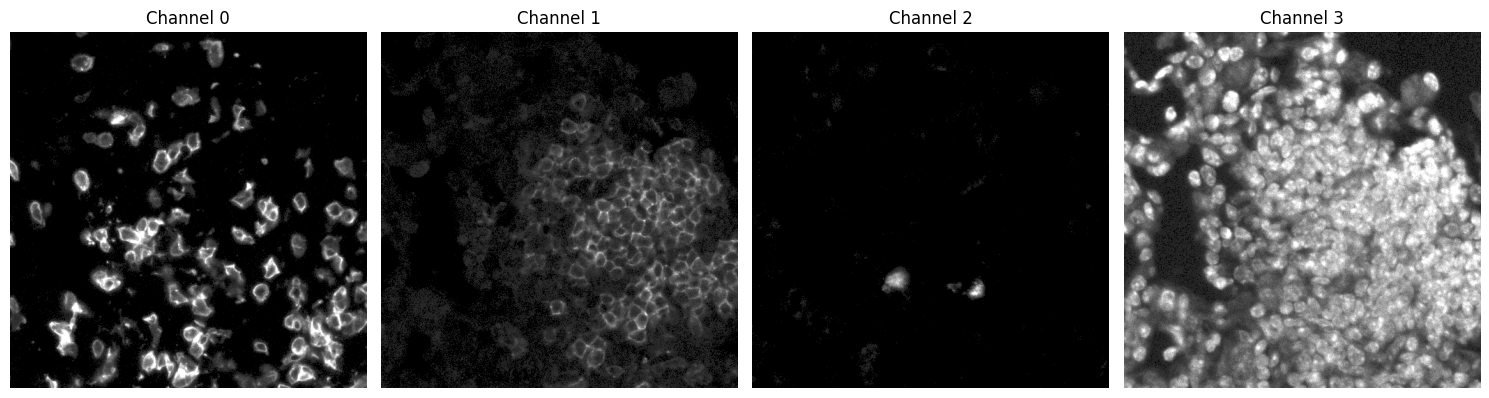

In [10]:
### Tile variation
# Checking different tiles:
#tile_filename = "tile_0002_0025"
#tile_filename = "tile_0003_0010"
#tile_filename = "tile_0000_0038"
#tile_filename = "tile_0002_0031"
tile_filename = "tile_0028_0011_image"

channel_count = 4  # Adjust according to the number of channels
input_path = "/work/imaging_analysis_f2805_HEV/output_tiles/scene_0/"  # Path to the directory where the tiles are stored

tile_variance_dict = get_tile_variance(tile_filename, channel_count, tile_size=512, overlap=0, input_path=input_path)